---

<center><h1 style="font-size:40px;">Project 1<br>Image Segmentation using CNNs</h1></center>

---

William Wahlberg

In this project, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique shape or color. In this project, your goal is to successfully run a segmentation program to segment different shapes from Flying Object dataset.

Good luck!

---

In [1]:
import torch
from torch import nn
import os
import imageio
import torchvision
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict 
from torch import optim
import time
import numpy as np
from PIL import Image
from torchvision.transforms import functional as TF

In [2]:
training_img_dir = "../FlyingObjectDataset_10K/training"
validation_img_dir = "../FlyingObjectDataset_10K/validation"
testing_img_dir = "../FlyingObjectDataset_10K/testing"

# Task 1
Based on the code provided for the previous lab adapt the ```FlyingObjects``` class so as it can be used for the ```Semantic Segmentation``` project.

Do not forget to go through the folders go get an idea of what they contain: ```gt_images``` will be our ground truth and ```image``` our images as in the previous lab.

Now that you have your ```Dataset``` class. Create your three splits using ```Dataloader```. If you desire you can use the ```image_with_labels``` from the previous lab to visualize both image and semantic segmentation maps.

## Create model
During training process the training loss can not only stop decreasing but also go far from a desired value. This occured due to the vanishing gradient. This can be observed as for every layer that we go backwards in the network gradient gets smaller and smaller.

Skip connections in deep architectures, skip some layer in the neural network and feeds the output of one layer as the input to the next layers. This provide an alternative path for the gradient during backpropagation. Therefore, the skip connections help to preserve the gradient.

Skip connections is also very popular for semantic segmentation where information captured in the initial layers also would like to be learned in later layers.
It has been observed that in earlier layers the learned features correspond to lower semantic information that is extracted from the input.

Therefore, for this project we will use skip connections for the auto encoder. More specifically, a U-Net. The skip connections are placed at each step of the encoder and feeding information to the decoder. The size of the input must be the same for both encoder and decoder where skip connections are applied.


![SegmentationModel](segmentation_proj.png)

In [3]:
class FlyingObjects(torch.utils.data.Dataset):
    """Dataset to Flying Object Dataset for the classification task.
       The label information is encoded on the filename, __extract_label will extract the label following the chosen granularity
    
    """
    def __init__(self, root,transform=None):
        super(FlyingObjects,self).__init__()
        self.root = root
        self.transform = transform
        
        self.images = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/image')) for f in fn if f.endswith(".png")]        
        self.images.sort()

        self.labels = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/gt_image')) for f in fn if f.endswith(".png")]
        self.labels.sort()

    def rgb_to_class_id(self, y, color_to_class_id):
        
        class_id_image = np.zeros((y.shape[0], y.shape[1]), dtype=int)
        
        for rgb, class_id in color_to_class_id.items():
            mask = np.all(y == np.array(rgb, dtype=np.uint8), axis=-1)
            class_id_image[mask] = class_id

        return class_id_image

    def __getitem__(self, index):
        x = imageio.v2.imread(self.images[index])
        y = imageio.v2.imread(self.labels[index])

        color_to_class_id = {
            (0, 0, 0): 0,  # Blue to class 0
            (255, 0, 0): 1,  # Red to class 1
            (0, 255, 0): 2,  # Green to class 2
            (0, 0, 255): 3,  # Blue to class 3
        }
        y = self.rgb_to_class_id(y, color_to_class_id)
        #print("after rgb to id", y.shape)

        if self.transform:
            x = self.transform(x)  # Apply transform to the image
            y = np.expand_dims(y, axis=2)  # Add a channel-like dimension to y for the transform
            y = self.transform(y)  # Apply the same transform to y
            y = y.squeeze(0)  # Remove the added channel dimension
        else:
            x = torch.from_numpy(x).float().permute(2, 0, 1)  # Reorder dimensions
            y = torch.from_numpy(y)

        return x, y

    def __len__(self):
        return len(self.images)
    




In [4]:

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64))
])

training_set = FlyingObjects(training_img_dir, transform=transform)
validation_set = FlyingObjects(validation_img_dir, transform=transform)
testing_set = FlyingObjects(testing_img_dir, transform=transform)

train_loader = DataLoader(training_set, batch_size=4, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=4, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=4, shuffle=True)

print(f"nr of batches: train:{len(train_loader)} valid:{len(val_loader)} test:{len(test_loader)}")

d, test = training_set.__getitem__(0)
print(d.shape)
print(test.shape)

counts = torch.bincount(test.view(-1))

for i, count in enumerate(counts):
    if count > 0:
        print(f"Value {i} appears {count} times")


nr of batches: train:2705 valid:561 test:555
torch.Size([3, 64, 64])
torch.Size([64, 64])
Value 0 appears 3691 times
Value 1 appears 265 times
Value 2 appears 140 times


In [5]:
class SimpleModel(nn.Module):
    def __init__(self, in_channels:int=3, n_classes:int=4, **kwargs):  # Set n_classes to 4
        super(SimpleModel, self).__init__()
        
        # Encoder
        self.conv1 = self.Encoder(in_channels, 32, 7, 3)
        self.conv2 = self.Encoder(32, 64, 3, 1)
        
        # Decoder
        self.upconv2 = self.Decoder(64, 32, 3, 1)
        self.upconv1 = self.Decoder(32*2, n_classes, 3, 1)  # Output channels set to 4

    def forward(self, x):

        # Downsample
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        
        # Upsample
        upconv2 = self.upconv2(conv2)
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def Encoder(self, in_channels, out_channels, kernel_size, padding):

        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )


    def Decoder(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )

In [6]:
def display_images_labels_predictions(data_loader, model, num_images):
    model.eval()  
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            predictions = model(data)
            predictions = torch.argmax(predictions, dim=1)

            for i in range(num_images):
                plt.figure(figsize=(12, 4))

                # Display Image
                plt.subplot(1, 3, 1)
                plt.imshow(data[i].permute(1, 2, 0).cpu().numpy()) 
                plt.title("Image")
                plt.axis('off')

                # Display Label
                plt.subplot(1, 3, 2)
                plt.imshow(labels[i].cpu().numpy(), cmap='gray')
                plt.title("Label")
                plt.axis('off')

                # Display Prediction
                plt.subplot(1, 3, 3)
                plt.imshow(predictions[i].cpu().numpy(), cmap='gray')
                plt.title("Prediction")
                plt.axis('off')

                plt.show()

            break 

Do not forget to use Tensorboard. It really helps.

# Task 2

Adapt your previously coded function ```train function``` for the current task. Do not forget to select an appropriate ```loss``` function for the task.

In [7]:
def calculate_pixel_accuracy(y_pred, y_true):
    y_pred_classes = torch.argmax(y_pred, dim=1)
    correct = (y_pred_classes == y_true).float()
    accuracy = correct.sum() / correct.numel() * 100
    return accuracy

def calculate_iou(y_pred, y_true, n_classes=4):
    # Convert predictions to class indices
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    for cls in range(n_classes):  # Iterate over each class
        true_class = y_true == cls
        predicted_class = y_pred == cls
        if true_class.sum() == 0 and predicted_class.sum() == 0:
            iou_list.append(float('nan'))  # Avoid division by zero
        else:
            intersection = torch.logical_and(true_class, predicted_class).sum()
            union = torch.logical_or(true_class, predicted_class).sum()
            iou = intersection / union
            iou_list.append(iou.item())

    return sum(iou_list) / len(iou_list) 


def train_epoch(epoch, optimizer, loss, model, train_loader):
    total_loss = 0
    model.train()
    for batch_idx, (data, label) in enumerate(train_loader):

        y = model(data)

        loss_value = loss(y, label)
        loss_value.backward()
        total_loss += loss_value.item()
        optimizer.step()
        optimizer.zero_grad()
    return total_loss / len(train_loader)

def validate_epoch(epoch, loss, model, val_loader):
    total_loss = 0
    total_accuracy = 0
    total_iou = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            y = model(data)
           
            loss_value = loss(y,label)
            
            total_loss += loss_value.item()
            total_accuracy += calculate_pixel_accuracy(y, label)
            iou = calculate_iou(y, label)
            total_iou += iou if not math.isnan(iou) else 0
            
    return (total_loss/len(val_loader), total_accuracy/len(val_loader), total_iou / len(val_loader))

def a_proper_training(num_epoch, model, optimizer, loss, train_loader, val_loader):
    best_epoch = None
    best_model = None
    best_val_loss = None
    train_losses = list()
    val_losses = list()
    print("Begin Training")

    for epoch in range(num_epoch):
        start_time = time.time()  # Start time

        train_loss = train_epoch(epoch, optimizer, loss, model, train_loader)
        val_loss, accuracy, iou = validate_epoch(epoch, loss, model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if epoch == 0:
            best_val_loss = val_loss
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model=model
            best_epoch=epoch

        end_time = time.time()
        elapsed_time = end_time - start_time
        
        print(f"Epoch {epoch + 1}/{num_epoch} ", end="")
        print(f"Train_Loss = {round(train_loss,4)} ", end="")
        print(f"Valid_Loss = {round(val_loss,4)} ", end="")
        print(f"Accuracy = {round(accuracy.item(), 6)}% ", end="")
        print(f"IoU = {round(iou, 8)} ", end="")
        print(f"Elapsed_time = {round(elapsed_time)}s")
        
    return (best_model, best_epoch, train_losses, val_losses)

In [8]:
criterion = nn.CrossEntropyLoss()
my_model = SimpleModel(input_size=64, hidden_size=10, output_size=2, num_layers=2)
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

#best_model, best_epoch, train_losses, val_losses = a_proper_training(
#    1, my_model, optimizer, criterion, train_loader, val_loader
#)

# Task 3

We want to be able to compute the accuracy on the ```validation``` split at the end of each epoch. Adapt question 2 such that we can do so. 
Do not forget to put your model in ```eval``` when computing your predictions and put it back in ```train``` after.

In [9]:
criterion = nn.CrossEntropyLoss()
my_model = SimpleModel(input_size=64, hidden_size=10, output_size=2, num_layers=2)
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

best_model, best_epoch, train_losses, val_losses = a_proper_training(
    50, my_model, optimizer, criterion, train_loader, val_loader
)


Begin Training
Epoch 1/50 Train_Loss = 0.2613 Valid_Loss = 0.1567 Accuracy = 93.47406% IoU = 0.52430218 Elapsed_time = 93s
Epoch 2/50 Train_Loss = 0.0965 Valid_Loss = 0.0626 Accuracy = 98.615791% IoU = 0.87514096 Elapsed_time = 94s
Epoch 3/50 Train_Loss = 0.032 Valid_Loss = 0.0289 Accuracy = 99.077751% IoU = 0.91482957 Elapsed_time = 91s
Epoch 4/50 Train_Loss = 0.0198 Valid_Loss = 0.024 Accuracy = 99.197334% IoU = 0.92574365 Elapsed_time = 90s
Epoch 5/50 Train_Loss = 0.0159 Valid_Loss = 0.0232 Accuracy = 99.239418% IoU = 0.92665681 Elapsed_time = 90s
Epoch 6/50 Train_Loss = 0.013 Valid_Loss = 0.0215 Accuracy = 99.311081% IoU = 0.93546944 Elapsed_time = 92s
Epoch 7/50 Train_Loss = 0.0114 Valid_Loss = 0.0526 Accuracy = 98.019081% IoU = 0.88262626 Elapsed_time = 94s
Epoch 8/50 Train_Loss = 0.0104 Valid_Loss = 0.0205 Accuracy = 99.36602% IoU = 0.93898166 Elapsed_time = 93s
Epoch 9/50 Train_Loss = 0.009 Valid_Loss = 0.0216 Accuracy = 99.325775% IoU = 0.93545785 Elapsed_time = 94s
Epoch 10/5

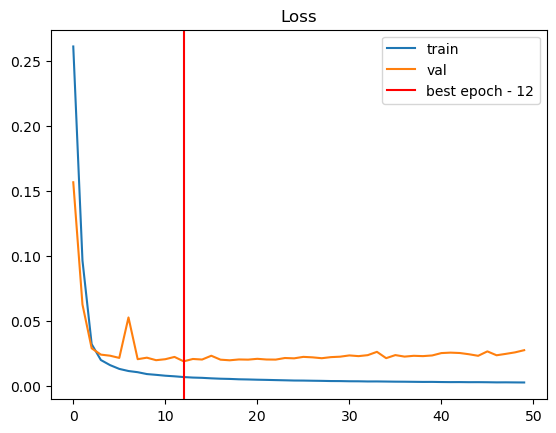

In [11]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.axvline(x = best_epoch, color = 'r', label = f"best epoch - {best_epoch}")
plt.title("Loss")
plt.legend()


<class '__main__.SimpleModel'>


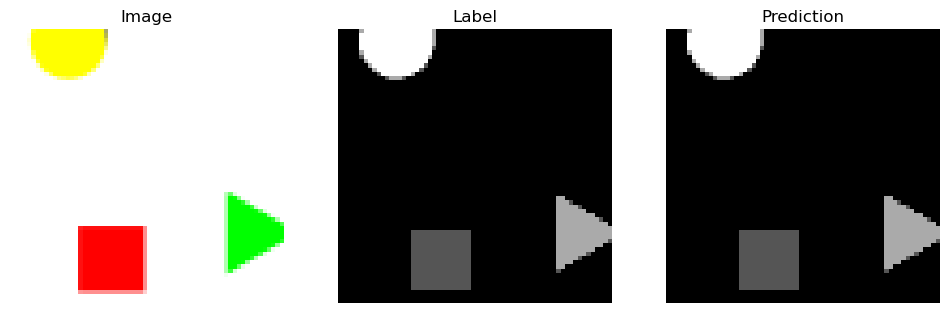

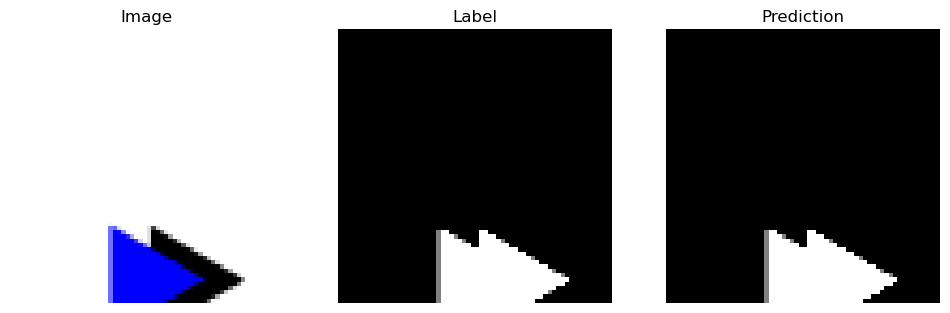

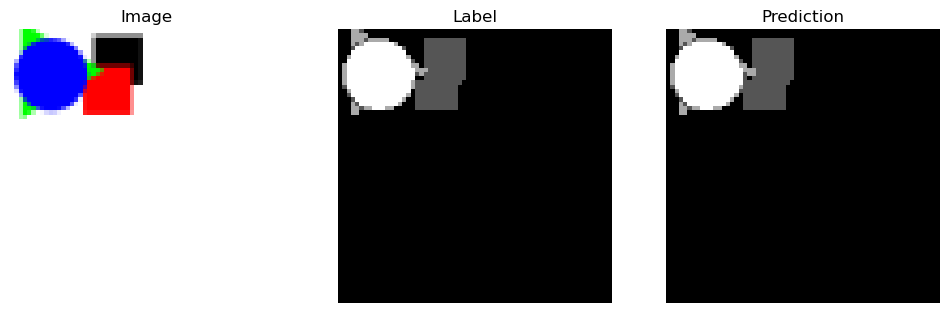

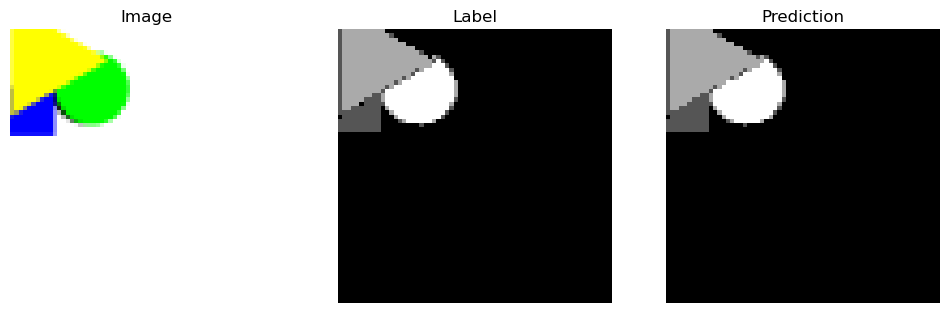

In [13]:
print(type(best_model))
display_images_labels_predictions(train_loader, best_model, 4)


# Task 4

Is ```accuracy```  a good metric for the task at hand? Why? ```hint:``` Try to compare your results ```qualitatively``` and ```quantitatively```.

In the context of segmentation with potentially imbalanced classes, accuracy is not a not metric. The constant 100% accuracy value when both the training and validation accuracy is lowering show that one should not make an assuption ragarding the models persorrmance based on accuracy.

# Task 5

If you answered in a negative way for Question 5, which would be a better metric for the task? Can you use it for the current project? Don't forget to present your answers in the seminar.

A common metric for semantic segmentation is Intersection over Union (IoU). It is a measure of the overlap between predicted segmentation and ground truth, calculated as the area of overlap divided by the area of union. Higher IoU indicates better accuracy.

# Task 6

As we did for the classification lab, go through the transformation documention. Did you find any that helps? Why?

In [14]:
import random
from torchvision.transforms import functional as TF

class JointTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, label):
        # Apply joint transformations
        if self.transform:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)

            # Random vertical flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                label = TF.vflip(label)

            # Add other joint transformations as needed

        return image, label
    
class FlyingObjects(torch.utils.data.Dataset):
    """Dataset to Flying Object Dataset for the classification task.
       The label information is encoded on the filename, __extract_label will extract the label following the chosen granularity
    
    """
    def __init__(self, root,transform=None):
        super(FlyingObjects,self).__init__()
        self.root = root
        self.transform = transform
        
        self.images = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/image')) for f in fn if f.endswith(".png")]        
        self.images.sort()

        self.labels = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/gt_image')) for f in fn if f.endswith(".png")]
        self.labels.sort()

    def rgb_to_class_id(self, y, color_to_class_id):
        y_np = np.array(y)  # Convert PIL Image to NumPy array
        class_id_image = np.zeros((y_np.shape[0], y_np.shape[1]), dtype=int)

        for rgb, class_id in color_to_class_id.items():
            mask = np.all(y_np == np.array(rgb, dtype=np.uint8), axis=-1)
            class_id_image[mask] = class_id

        return class_id_image
    
    def __getitem__(self, index):
        x = Image.open(self.images[index])
        y = Image.open(self.labels[index])

        # Apply joint transform
        joint_transform = JointTransform(self.transform)
        x, y = joint_transform(x, y)

        # Convert to NumPy arrays after joint transform
        x_np = np.array(x)
        y_np = np.array(y)

        # Define the color to class ID mapping
        color_to_class_id = {
            (0, 0, 0): 0,  # Black to class 0
            (255, 0, 0): 1,  # Red to class 1
            (0, 255, 0): 2,  # Green to class 2
            (0, 0, 255): 3,  # Blue to class 3
        }

        y_np = self.rgb_to_class_id(y_np, color_to_class_id)

        # Convert the NumPy arrays to tensors
        x_tensor = TF.to_tensor(x_np)
        y_tensor = torch.from_numpy(y_np)

        return x_tensor, y_tensor


    def __len__(self):
        return len(self.images)
    




In [15]:

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Random crop and then resize
    torchvision.transforms.RandomRotation(degrees=3),  # Random rotation
    torchvision.transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    torchvision.transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    torchvision.transforms.Resize((64, 64))
])

training_set = FlyingObjects(training_img_dir, transform=transform)
validation_set = FlyingObjects(validation_img_dir, transform=transform)
testing_set = FlyingObjects(testing_img_dir, transform=transform)

train_loader = DataLoader(training_set, batch_size=4, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=4, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=4, shuffle=True)

print(f"nr of batches: train:{len(train_loader)} valid:{len(val_loader)} test:{len(test_loader)}")

d, test = training_set.__getitem__(0)
print(d.shape)
print(test.shape)

counts = torch.bincount(test.view(-1))

for i, count in enumerate(counts):
    if count > 0:
        print(f"Value {i} appears {count} times")


nr of batches: train:2705 valid:561 test:555
torch.Size([3, 128, 128])
torch.Size([128, 128])
Value 0 appears 14717 times
Value 1 appears 1058 times
Value 2 appears 609 times


In [16]:
criterion = nn.CrossEntropyLoss()
my_model = SimpleModel(input_size=64, hidden_size=10, output_size=2, num_layers=2)
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

best_model_2, best_epoch_2, train_losses_2, val_losses_2 = a_proper_training(
    50, my_model, optimizer, criterion, train_loader, val_loader
)


Begin Training
Epoch 1/50 Train_Loss = 0.172 Valid_Loss = 7.6738 Accuracy = 34.390774% IoU = 0.45810875 Elapsed_time = 225s
Epoch 2/50 Train_Loss = 0.0247 Valid_Loss = 0.0173 Accuracy = 99.587288% IoU = 0.96635637 Elapsed_time = 228s
Epoch 3/50 Train_Loss = 0.0112 Valid_Loss = 3.5981 Accuracy = 43.242924% IoU = 0.33906893 Elapsed_time = 230s
Epoch 4/50 Train_Loss = 0.0072 Valid_Loss = 0.0106 Accuracy = 99.696854% IoU = 0.97505731 Elapsed_time = 231s
Epoch 5/50 Train_Loss = 0.0057 Valid_Loss = 0.0062 Accuracy = 99.775635% IoU = 0.97642688 Elapsed_time = 232s
Epoch 6/50 Train_Loss = 0.0049 Valid_Loss = 0.0055 Accuracy = 99.800804% IoU = 0.98228872 Elapsed_time = 228s
Epoch 7/50 Train_Loss = 0.0044 Valid_Loss = 0.0058 Accuracy = 99.79335% IoU = 0.9781727 Elapsed_time = 195s
Epoch 8/50 Train_Loss = 0.0039 Valid_Loss = 0.0045 Accuracy = 99.832756% IoU = 0.9833078 Elapsed_time = 162s
Epoch 9/50 Train_Loss = 0.0039 Valid_Loss = 0.006 Accuracy = 99.823593% IoU = 0.98083889 Elapsed_time = 195s


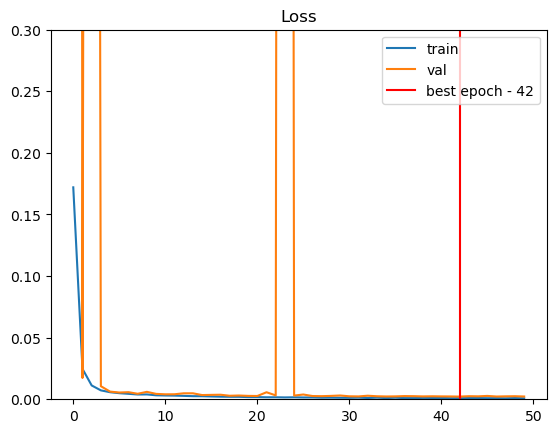

In [24]:
plt.plot(train_losses_2, label="train")
plt.plot(val_losses_2, label="val")
plt.axvline(x = best_epoch_2, color = 'r', label = f"best epoch - {best_epoch_2}")
plt.title("Loss")
plt.ylim(top=0.3)  # adjust the top leaving bottom unchanged
plt.ylim(bottom=0)  # adjust the bottom leaving top unchanged
plt.legend()


<class '__main__.SimpleModel'>


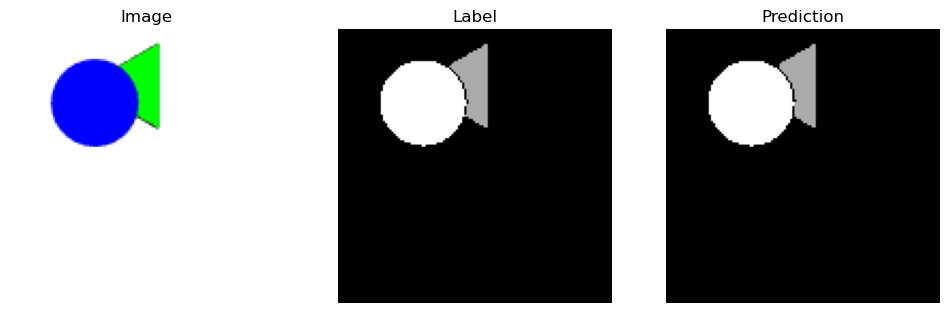

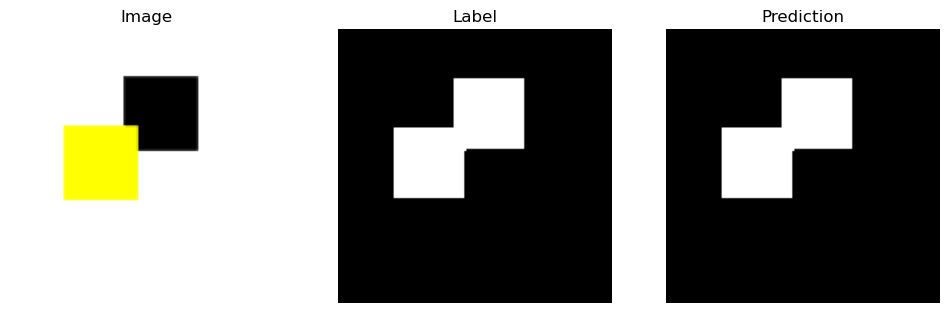

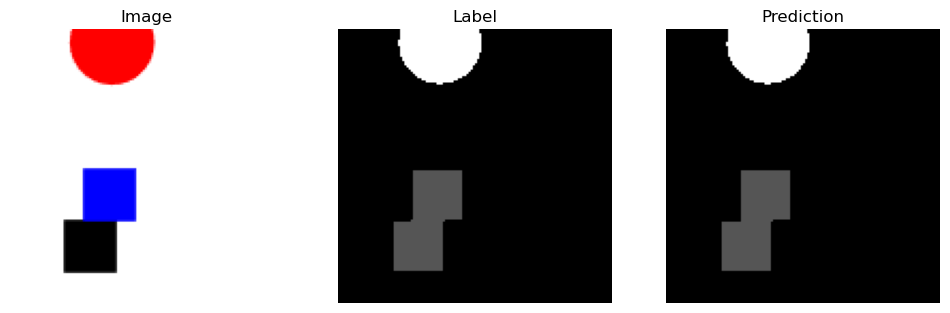

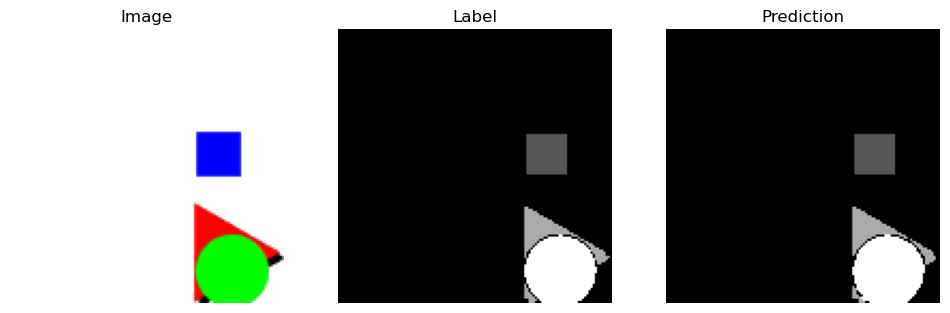

In [18]:
print(type(best_model))
display_images_labels_predictions(train_loader, best_model_2, 4)
